In [198]:
#Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras
from   tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

In [200]:
#create labels
classes=[]
filename=r"C:\\Users\\admin\\MRI_dataset"
for sub_folder in os.listdir(os.path.join(filename,'Train_set')):
    classes.append(sub_folder)
print(classes)

['Glioma_tumor', 'Meningioma_tumor', 'No_tumor', 'Pituitary_tumor']


In [201]:
#resize images using OpenCV and put together the Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Train_set',i)
    for j in tqdm(os.listdir(path_train)): #Real-time smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Test_set',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 94.62it/s]


In [202]:
print(X_train.shape)
print(y_train.shape)

(3264, 160, 160, 3)
(3264,)


In [203]:
#Data Augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)

#A labelencoder is used to convert labels in strings to integers
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

#fitting and transforming the labels to intergers
labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)


In [225]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2774, 160, 160, 3)
(490, 160, 160, 3)
(2774,)
(490,)


In [226]:
#setting up the model
tf.random.set_seed(79)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='elu',kernel_initializer='GlorotNormal', input_shape=(image_size,image_size, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.Activation('linear'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.Dense(38, activation='elu',kernel_initializer='GlorotNormal'),
    tf.keras.layers.Dropout(rate=0.15),
    tf.keras.layers.Dense(4, activation='softmax')
      ])
opt = Adam(
    learning_rate=0.00007,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

#summarize the model
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 158, 158, 16)      448       
                                                                 
 batch_normalization_16 (Ba  (None, 158, 158, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 79, 79, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 77, 77, 32)        4640      
                                                                 
 activation_4 (Activation)   (None, 77, 77, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 38, 38, 32)       

In [227]:
#setup early stopping
early_stopping_cb=keras.callbacks.EarlyStopping(patience=15,restore_best_weights=True)

#Train the model
history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=35,
    batch_size=9,callbacks=[early_stopping_cb])


Epoch 1/35
309/309 [==============================] - 28s 83ms/step - loss: 1.0519 - accuracy: 0.5606 - val_loss: 0.9235 - val_accuracy: 0.6000
Epoch 2/35
309/309 [==============================] - 24s 76ms/step - loss: 0.7795 - accuracy: 0.6853 - val_loss: 0.8396 - val_accuracy: 0.6367
Epoch 3/35
309/309 [==============================] - 24s 76ms/step - loss: 0.6462 - accuracy: 0.7487 - val_loss: 0.5930 - val_accuracy: 0.7653
Epoch 4/35
309/309 [==============================] - 24s 77ms/step - loss: 0.5216 - accuracy: 0.8043 - val_loss: 0.6873 - val_accuracy: 0.7388
Epoch 5/35
309/309 [==============================] - 24s 77ms/step - loss: 0.4336 - accuracy: 0.8443 - val_loss: 0.4311 - val_accuracy: 0.8429
Epoch 6/35
309/309 [==============================] - 24s 77ms/step - loss: 0.3312 - accuracy: 0.8789 - val_loss: 0.6321 - val_accuracy: 0.8041
Epoch 7/35
309/309 [==============================] - 24s 77ms/step - loss: 0.2900 - accuracy: 0.8998 - val_loss: 0.4609 - val_accuracy:

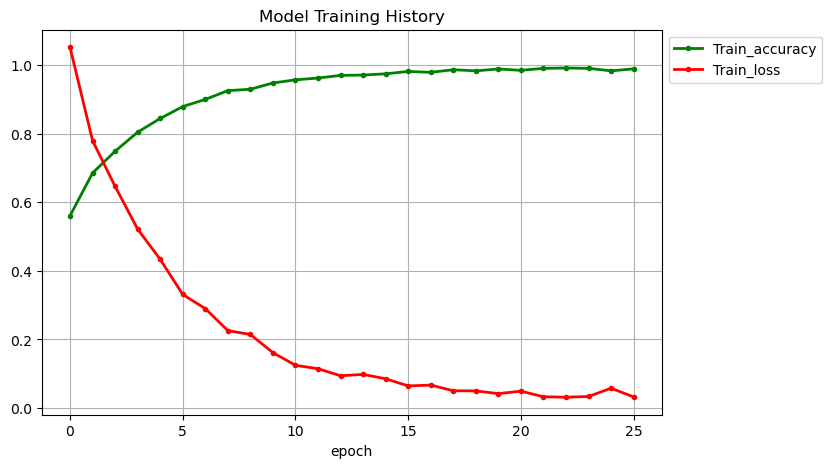

In [229]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.plot(history.history['accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.legend(['Train_accuracy', 'Train_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [230]:
train_loss, train_accuracy = model.evaluate(X_train,y_train)

print('Accuracy: %f' % (train_accuracy*100))

87/87 [==============================] - 5s 53ms/step - loss: 0.0289 - accuracy: 0.9971
Accuracy: 99.711609


In [244]:
val_loss, val_accuracy = model.evaluate(X_test,y_test)

print('Accuracy: %f' % (accuracy*100))

16/16 [==============================] - 1s 52ms/step - loss: 0.2678 - accuracy: 0.9082
Accuracy: 90.816325


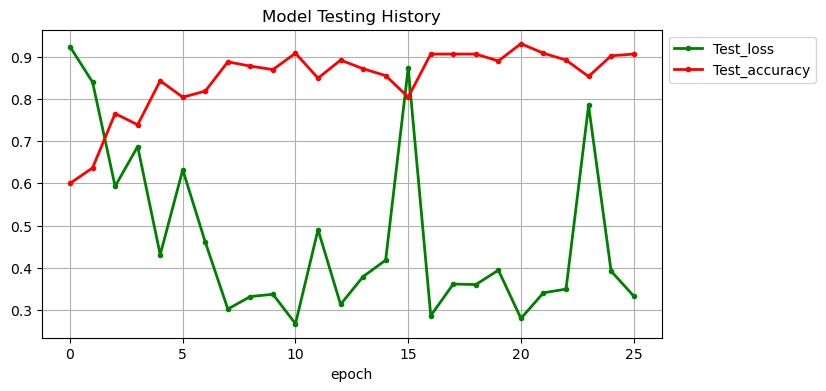

In [245]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['val_loss'], '.g-', linewidth=2)
plt.plot(history.history['val_accuracy'], '.r-', linewidth=2)
plt.title('Model Testing History')
plt.xlabel('epoch')
plt.legend(['Test_loss', 'Test_accuracy'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

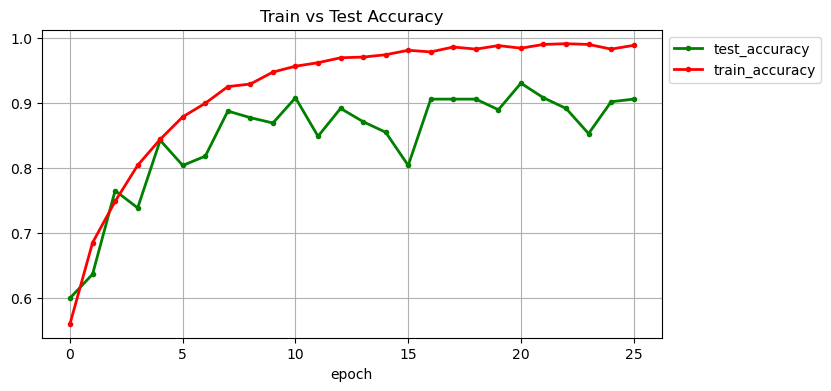

In [246]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['val_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['accuracy'], '.r-', linewidth=2)
plt.title('Train vs Test Accuracy')
plt.xlabel('epoch')
plt.legend(['test_accuracy', 'train_accuracy'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

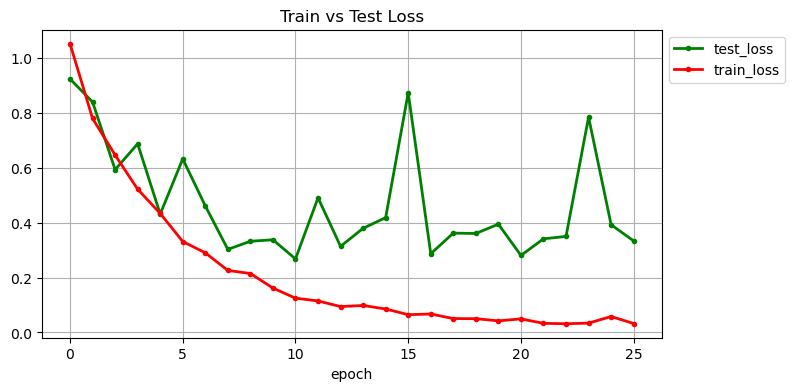

In [247]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['val_loss'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Train vs Test Loss')
plt.xlabel('epoch')
plt.legend(['test_loss', 'train_loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [248]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

In [249]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)

#predicted labels
pred_labels=lb.inverse_transform(pred) 

16/16 [==============================] - 1s 51ms/step


Text(95.72222222222221, 0.5, 'Predicted class')

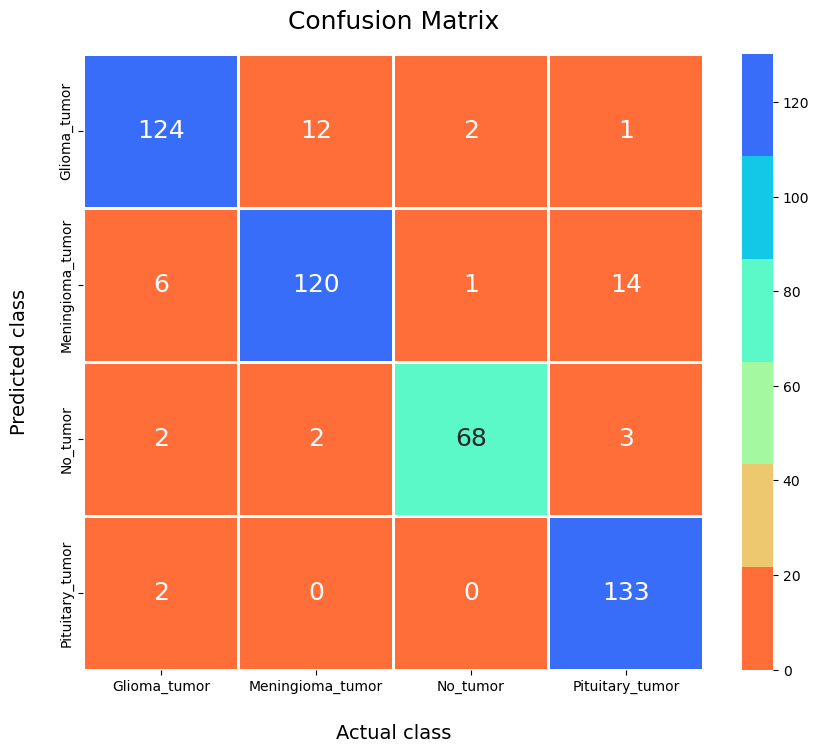

In [251]:
#Plots the confusion matrix
cm = confusion_matrix(y_test,pred)

fig,ax= plt.subplots(figsize=(10,8))

a=sns.color_palette("rainbow_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [252]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    Glioma_tumor       0.93      0.89      0.91       139
Meningioma_tumor       0.90      0.85      0.87       141
        No_tumor       0.96      0.91      0.93        75
 Pituitary_tumor       0.88      0.99      0.93       135

        accuracy                           0.91       490
       macro avg       0.91      0.91      0.91       490
    weighted avg       0.91      0.91      0.91       490



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

16/16 [==============================] - 1s 52ms/step


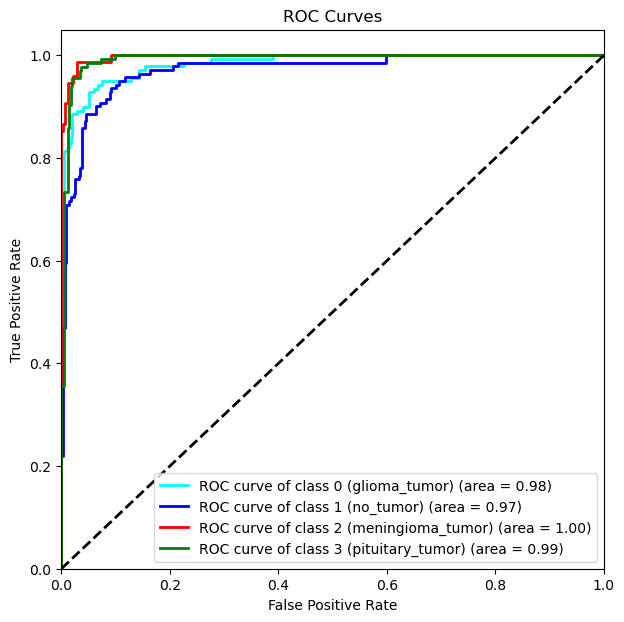

In [253]:
# Get predictions
predictions = model.predict(X_test)
y_score = predictions
y_pred = np.argmax(predictions, axis=1)
y_true = y_test

# Classes
labels_list = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

# One-hot encoding of true labels
y_true_one_hot = label_binarize(y_true, classes=np.arange(len(labels_list)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(labels_list)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(7, 7))
colors = cycle(['aqua', 'blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
             ''.format(i, labels_list[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [254]:
!pip install visualkeras
import visualkeras

Defaulting to user installation because normal site-packages is not writeable


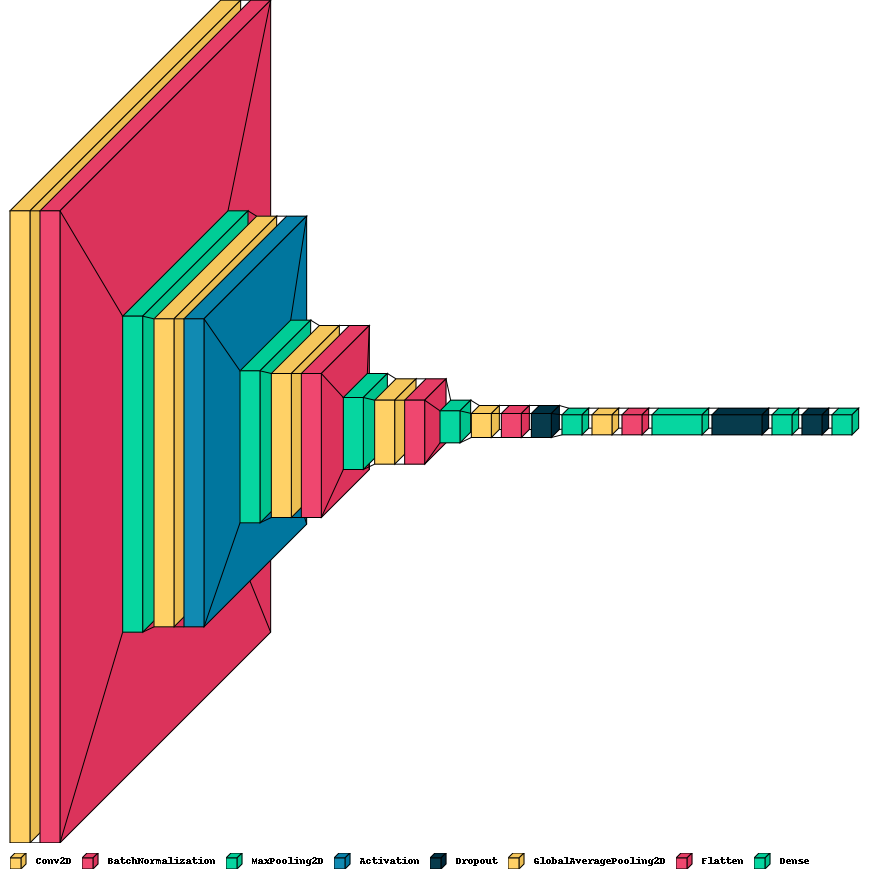

In [255]:
visualkeras.layered_view(model, legend = True)

1/1 [==============================] - 0s 147ms/step


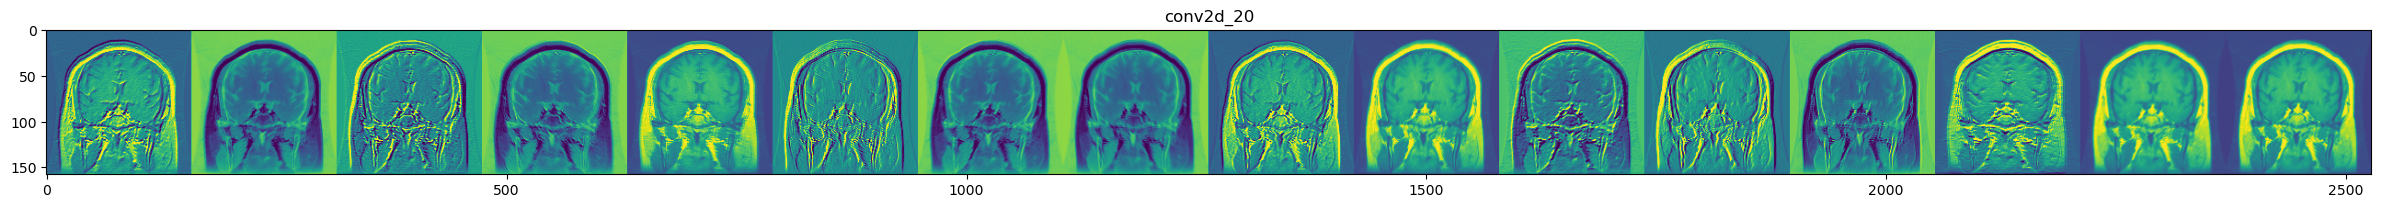

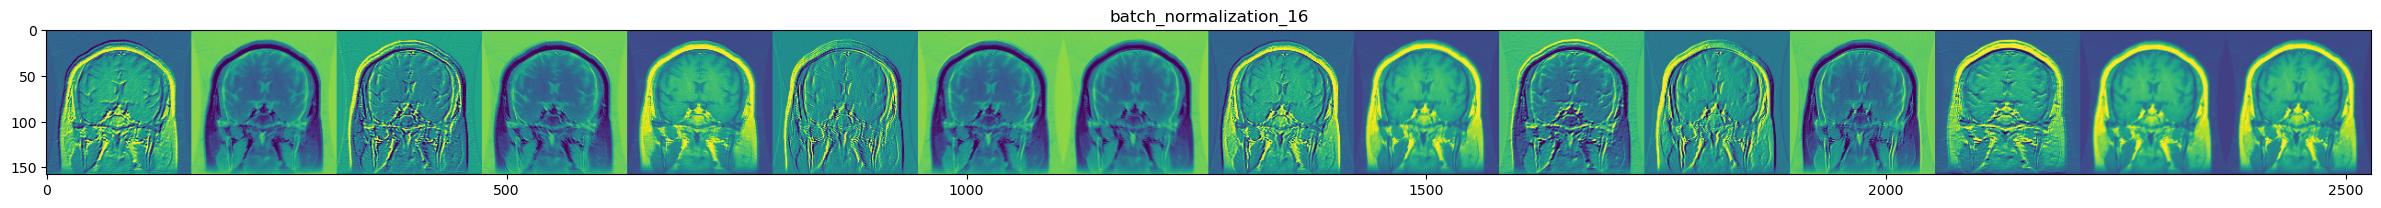

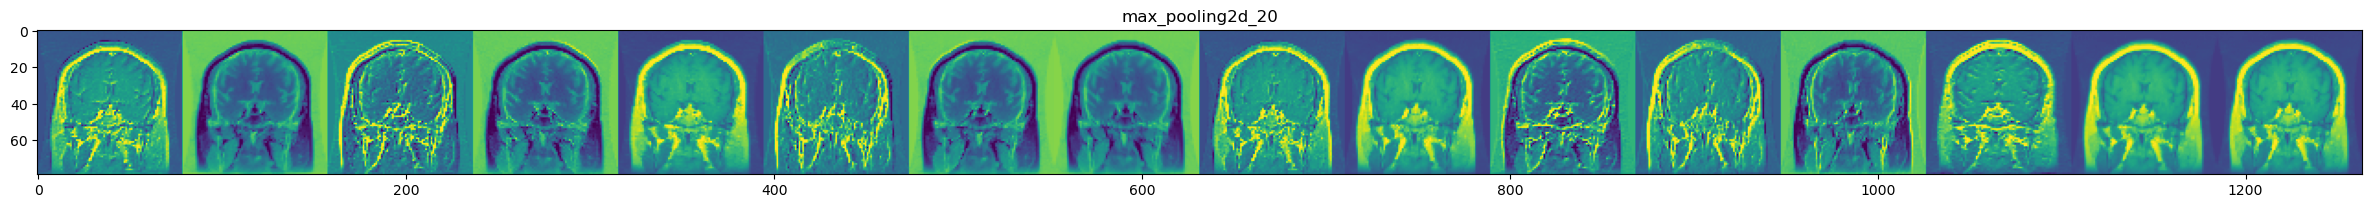

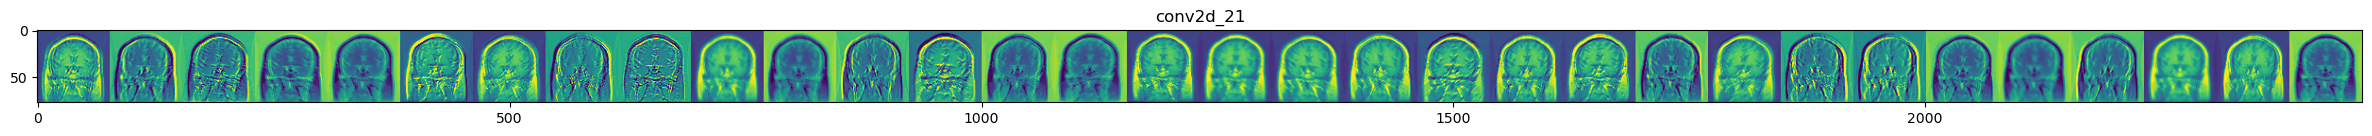

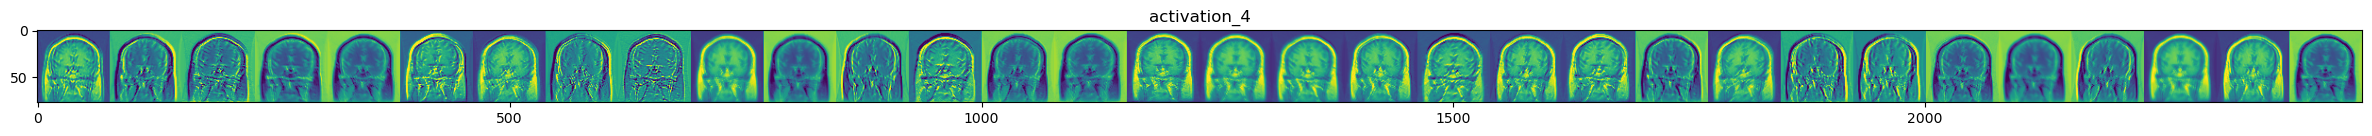

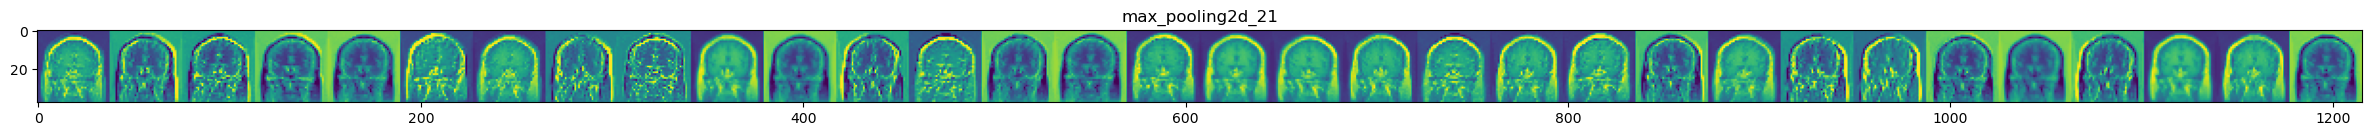

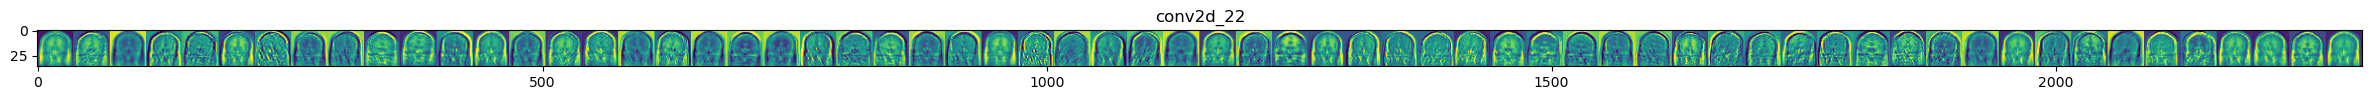

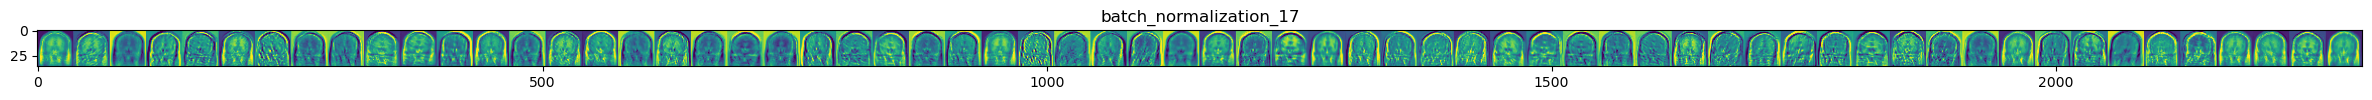

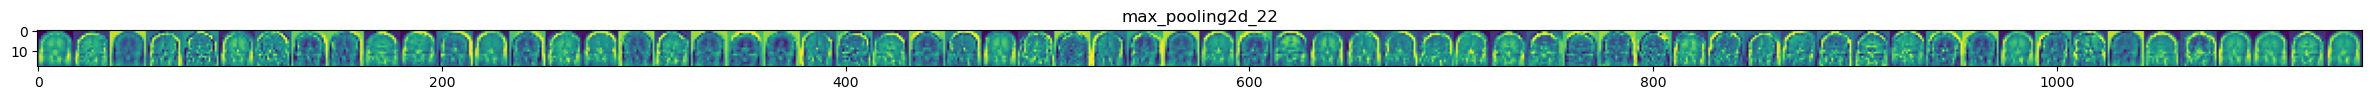

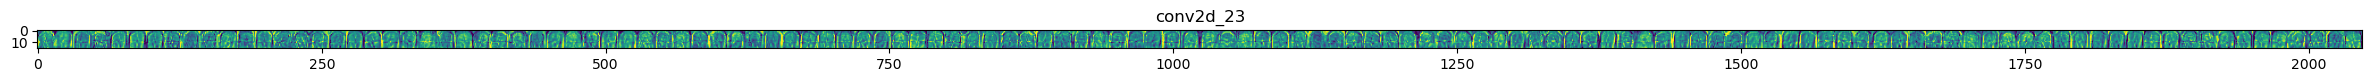

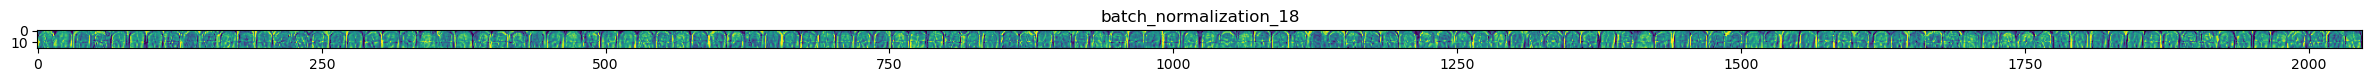

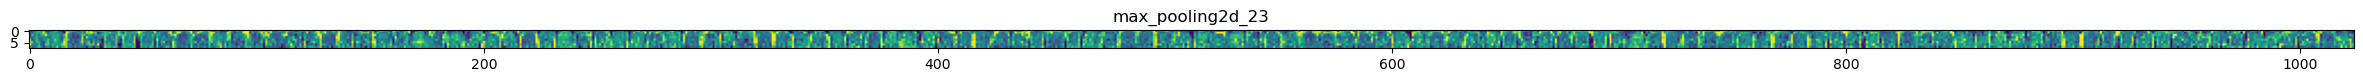

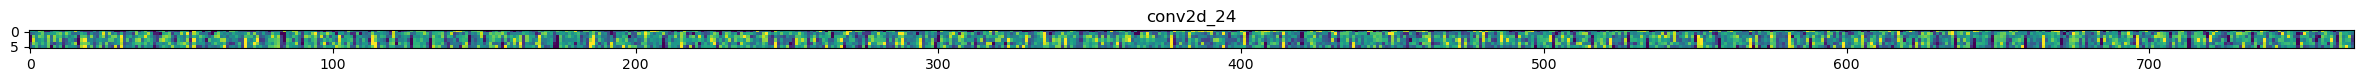

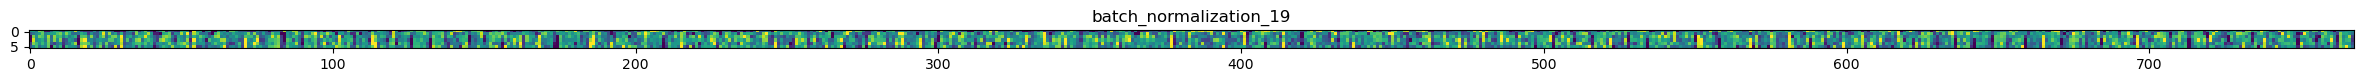

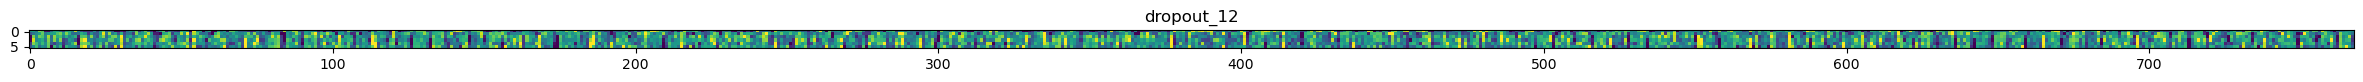

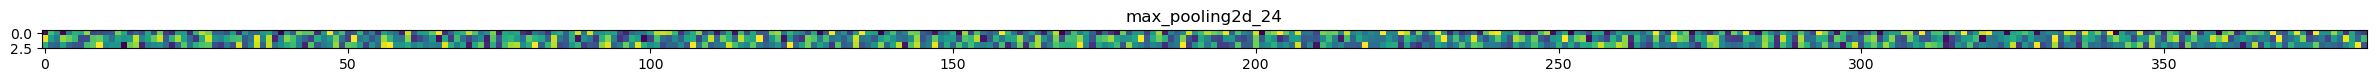

In [258]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Select a random input image of an MRI image from the training set.
x = random.choice(X_train)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 160, 160, 3)

# Rescale
x = x/255

# Run image through the model and obtain intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)

# Model layer names
layer_names = [layer.name for layer in model.layers]

#Show each layer representation
#Only convolutional and max pooling layers
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:

        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # Placing images in grids
        display_grid = np.zeros((size, size * n_features))

        #Feature post-processing
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #Dispaly the grid
        
        scale = 30. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )